## *Brazilian E-commerce Insights*

## *Data Mining*

 *Data Mining is the process of `discovering patterns`, `relationships`, and useful insights from large sets of data. It’s like finding valuable information hidden in a big pile of data*

### *Importing Libraries*

In [355]:
import warnings
import numpy as np
import pandas as pd
from IPython.display import display  
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns  
from scipy import stats
from plotly.subplots import make_subplots
import plotly.graph_objects as go  
from sklearn.preprocessing import StandardScaler 

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from wordcloud import WordCloud  # For generating word clouds from text data
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

warnings.filterwarnings("ignore")

In [323]:
df = pd.read_parquet('../data/final/olist_full_data_Loaded.parquet', engine='pyarrow')

## *1.Clustering (Unsupervised Learning)*
*Clustering is an unsupervised machine learning technique used to group similar data points together into clusters — where each group shares more similarities with each other than with those in other groups.*

### *K-Means*:
*K-Means clustering uses Euclidean distance to measure the distance between data points and cluster centroids.*
mathmatical formula for K-Means clustering is:
$$J = \sum_{i=1}^{k} \sum_{x_j \in C_i} ||x_j - \mu_i||^2$$
where:  
- \(J\) is the objective function (total distance within clusters)
- \(k\) is the number of clusters



### *I .Data Preprocessing for K-Means*
#### *Step 1:Choose Relevant Columns for Clustering*

*Since K-Means works only with numerical values, we need to pick columns that are:Meaningful for identifying groups of similar orders or customers*
- *Numerical*

In [324]:
features_to_cluster =  ['monetary_value', 'purchase_frequency', 'recency_days','review_score', 'profit_margin']
df_cluster = df[features_to_cluster].copy()

| *Feature*                  | *Meaning*                               | *Cluster Interpretation Example*                        |
|----------------------------|------------------------------------------|----------------------------------------------------------
| *review_score*             | *Customer satisfaction*                  | *Happy vs. unhappy buyers*                               |
|*profit_margin*              | *Profit margin of the product*          | *High vs. low profit margin products*                    |
| *recency_days*             | *Days since last purchase*               | *Recent vs. old customers*                               |
| *purchase_frequency*       | *How often the customer buys*            | *Frequent vs. rare buyers*                               |
| *monetary_value*           | *Total money spent by customer*          | *High-value vs. low-value customers*                     |
                           |


#### *Step 2: Handling Missing Values*

In [325]:
df_cluster.isnull().sum()
#checking if there are any inf or -inf values
print(np.isinf(df_cluster).sum())

monetary_value        0
purchase_frequency    0
recency_days          0
review_score          0
profit_margin         0
dtype: int64



#### *Step 3: Scaling the Data*
*K-Means is distance-based, so we must scale all features so that one with large values (e.g., monetary_value) doesn't dominate the clustering.*
##### *Mathematically*:

$$
z = \frac{x - \mu}{\sigma}
$$  
*Each column has mean = 0 and standard deviation 1*




In [326]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)

### *II.Elbow Method to Choose k*
*elbow method is a technique to determine the optimal number of `clusters (k) in K-Means clustering`. It involves plotting the sum of squared distances (inertia) between data points and their assigned cluster centroids for different values of k, and looking for an "elbow" point where the rate of decrease sharply changes.*

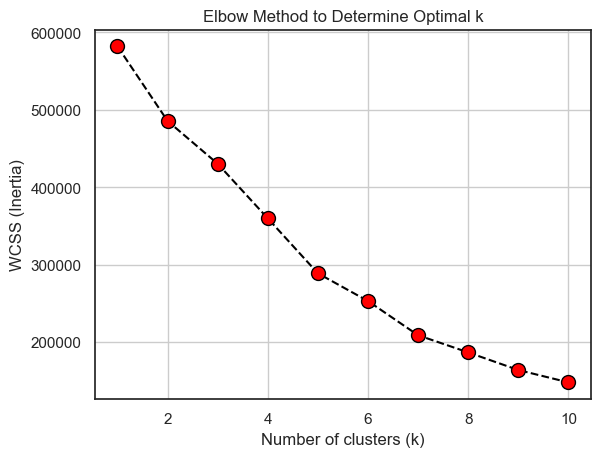

In [327]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss,  linestyle='--', color='black',marker='o' , markerfacecolor='red', markersize=10)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method to Determine Optimal k')
plt.grid(True)
plt.show()



### *Elbow Method Insights*
---

*Optimal Number of Clusters (k):*

*The "elbow" of the curve is at k=6, where the rate of decrease in WCSS slows down significantly.*
*This suggests that k=6 is the optimal number of clusters, balancing fit and simplicity.*

*Key Observations:*

*Sharp Drop: Between k=2 and k=4, WCSS decreases rapidly, indicating strong improvement in clustering.*

*Plateau: Beyond k=6, the curve flattens, showing minimal improvement in WCSS. Adding more clusters may lead to overfitting.*

*Recommendations:*

*Best Choice: k=6 captures the main structure with minimal complexity.*

*Alternative: k=4 can be considered if domain knowledge supports subgroups.*

*Avoid: k > 6 as gains are minimal, and interpretability decreases.*

*Business Implications*
*Using `k=6` clusters can help identify distinct customer groups for targeted marketing, loyalty programs, or operational improvements.*

---


#### *III.Choosing and Applying  k=6*
*Based on the elbow method, we choose k=6 as the optimal number of clusters for our K-Means model.*
The following  steps will be:

*Applying  K-mean algorithm with k=6 to the dataset and assigning each data point to its respective cluster.*

*Then fit the model to the data and predict the cluster labels for each data point.*



In [328]:
final_k = 6
kmeans = KMeans(n_clusters=final_k, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(scaled_data)

### *IV.Cluster Profiling – Understanding Each Cluster*
*Why Cluster Profiles Matter :will answer the question of what each cluster represents and how to use it for business decisions.*

Some of the questions that cluster profiles can help answer include:
- *Are some clusters high-value customers?*
- *Do some clusters represent low-profit, high-weight products?*
- *How do the clusters differ in terms of customer behavior?*
- *What marketing strategies can be tailored for each cluster?*                     

In [329]:
df_cluster=df_cluster.groupby('cluster').mean(numeric_only=True).round(2)

#### **Key Observations**:
---
🔵**Cluster 0**:
  *Moderate overall metrics,* **with a strong review score (4.66)**, suggesting customers are fairly satisfied.

  *May be retained with regular engagement.*

🔴**Cluster 1**:
  **Low review score (1.59)** *despite fair monetary value and profit margin.*

  *Could signal service/product issues that require quality improvement.*

🟠**Cluster 2**:
  **Extremely high monetary value (109,312.64) and profit margin (13,636.07)** — *but alarmingly low review score (1.00).*
  **Represents dissatisfied but valuable clients**, possibly **bulk buyers** or **B2B clients needing better service follow-up**.

🟡**Cluster 3**:
  *Similar in profile to Cluster 0,* but **extremely high recency (397.64)** indicates **inactivity**.

  *Should be re-engaged through reactivation campaigns.*

🟢 **Cluster 4**:
  **High monetary value (7,544.95) and strong profit margin (1,486.24)** — *possibly premium customers.*

  *Slightly lower satisfaction (3.51), which may be improved to strengthen loyalty.*

💙**Cluster 5**:
  **High purchase frequency (7.11)** *with a solid review score (4.41)* and **decent monetary value**.

  **Highly loyal and satisfied customers** — **best candidates for loyalty programs or special offers**.

---

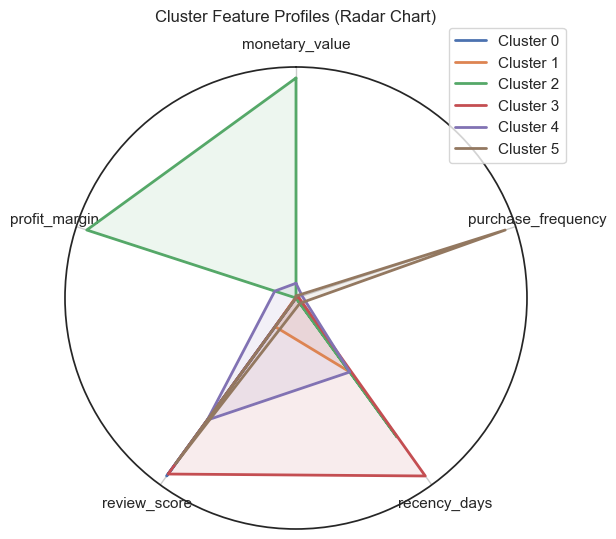

In [330]:
# Prepare cluster profile data
cluster_profile = df_cluster.groupby('cluster')[['monetary_value', 'purchase_frequency', 'recency_days', 'review_score', 'profit_margin']].mean()

# Normalize the values for better comparison
cluster_normalized = (cluster_profile - cluster_profile.min()) / (cluster_profile.max() - cluster_profile.min())

# Radar chart settings
features = cluster_normalized.columns
N = len(features)
angles =  np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Create radar chart figure
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Set the start angle to 90 degrees (top of the plot)
ax.set_theta_offset(np.pi / 2)
# Set the direction to clockwise
ax.set_theta_direction(-1)

# Plot each cluster's radar line
for i, row in cluster_normalized.iterrows():
    values = row.tolist()
    values += values[:1]  # close the loop
    ax.plot(angles, values, label=f'Cluster {i}', linewidth=2)
    ax.fill(angles, values, alpha=0.1)

# Add feature labels and legend
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)
ax.set_yticks([])
plt.title("Cluster Feature Profiles (Radar Chart)", y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()



---

#### *General Interpretation of Customer Clusters (Radar Chart)*

The radar chart visualizes distinct customer segments based on behavioral patterns across several key dimensions: *monetary value, profit margin, purchase frequency, review score,* and *recency*. Each cluster represents a group of customers with similar characteristics, allowing for targeted business strategies.

---

####  *Cluster A – High Spending, Low Satisfaction*

*These customers contribute significantly to revenue and profit but report lower satisfaction levels.*
*This may indicate underlying service or product quality issues that need to be addressed.*

---

#### *Cluster B – Frequent and Satisfied Buyers*

*Customers in this group purchase regularly and provide positive reviews.*
*They are likely loyal and engaged, representing a valuable base for brand advocacy and referral campaigns.*

---

#### *Cluster C – Previously Active, Now Inactive*

*This segment shows high recency, meaning these customers haven’t purchased recently.*
*They may have once been active and valuable but now require re-engagement strategies such as win-back offers.*

---

#### *Cluster D – Low Engagement Across All Dimensions*

*These customers show minimal activity and low impact across all metrics.*
*They may not warrant focused investment unless there's potential for growth.*

---

### *Overall Trend*

*Customer behavior is diverse and segmented—some are highly profitable but dissatisfied, others are loyal and engaged, while some are drifting away or minimally involved. Understanding these patterns supports more effective decision-making around retention, engagement, and resource allocation.*

---


### *NLP:Natural Language Processing*

In [331]:
#read the csv file
df1 = pd.read_csv('../data/raw/olist_order_reviews_dataset.csv')
df2 = pd.read_csv('../data/raw/olist_products_dataset.csv')
#concatenate the two dataframes
df = pd.concat([df1, df2], axis=1)

In [332]:
nlp_df = df[['review_comment_title', 'review_comment_message', 'product_category_name']]

### *Data Cleaning*

In [333]:
print("There are {} product categories in the dataset.".format(nlp_df.product_category_name.nunique()))

There are 73 product categories in the dataset.


In [334]:
# Calculating the total number of NaN values in each column of the DataFrame 'nlp_df'
nan_counts = nlp_df.isna().sum()

In [335]:
# Calculating the total number of NaN values in the 'review_comment_message' column of 'nlp_df'
nan_count_review_comment_message = nlp_df['review_comment_message'].isna().sum()
nan_count_review_comment_message

np.int64(58247)

In [336]:
def remove_duplicates_nlp_df(nlp_df, column_name='review_comment_message'):
    
    # Remove duplicates based on the specified column, keeping the first occurrence
    nlp_df = nlp_df.drop_duplicates(subset=[column_name], keep='first').reset_index(drop=True)
    
    # Display the total entries after removing duplicates
    print(f"Total entries after removing duplicates in '{column_name}': {nlp_df.shape[0]}")
    
    return nlp_df

# Remove duplicates from 'nlp_df' based on the 'review_comment_message' column
nlp_df = remove_duplicates_nlp_df(nlp_df, 'review_comment_message')

# Display the first few records to verify
nlp_df.head()

Total entries after removing duplicates in 'review_comment_message': 36160


,review_comment_title,review_comment_message,product_category_name
0,NaN,NaN,perfumaria
1,NaN,Recebi bem antes do prazo estipulado.,bebes
2,NaN,Parabéns lojas lannister adorei comprar pela I...,utilidades_domesticas
3,recomendo,aparelho eficiente. no site a marca do aparelh...,brinquedos
4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\n",instrumentos_musicais


In [337]:
def clean_reviews(df):
    
    # Remove rows where 'review_comment_message' is empty
    df = df.dropna(subset=['review_comment_message', 'review_comment_title', 'product_category_name']).reset_index(drop=True)

    # Remove duplicate rows
    df = df.drop_duplicates(subset=['review_comment_message'])

    return df

# Assuming 'nlp_df' is your dataframe
df_cleaned = clean_reviews(nlp_df)

# Display the first records to check
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3018 entries, 0 to 3017
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_comment_title    3018 non-null   object
 1   review_comment_message  3018 non-null   object
 2   product_category_name   3018 non-null   object
dtypes: object(3)
memory usage: 70.9+ KB


In [338]:
import re

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Apply to the cleaned DataFrame
df_cleaned['review_comment_message_clean'] = df_cleaned['review_comment_message'].apply(preprocess_text)
df_cleaned[['review_comment_message', 'review_comment_message_clean']].head()


,review_comment_message,review_comment_message_clean
0,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente no site a marca do aparelho...
1,"Vendedor confiável, produto ok e entrega antes...",vendedor confivel produto ok e entrega antes d...
2,Péssimo,pssimo
3,Loja nota 10,loja nota
4,Recebi exatamente o que esperava. As demais en...,recebi exatamente o que esperava as demais enc...


### *Text Preprocessing*

In [339]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize analyzer
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(df, column_name='review_comment_message_clean'):
    def get_sentiment_classification(text):
        scores = analyzer.polarity_scores(text)
        if scores['compound'] >= 0.05:
            return 'Positive'
        elif scores['compound'] <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    
    df[f'{column_name}_sentiment'] = df[column_name].map(get_sentiment_classification)
    return df

# Apply to cleaned and preprocessed data
df_sentiment = classify_sentiment(df_cleaned, 'review_comment_message_clean')
df_sentiment[['review_comment_message_clean', 'review_comment_message_clean_sentiment']].head(25)


,review_comment_message_clean,review_comment_message_clean_sentiment
0,aparelho eficiente no site a marca do aparelho...,Negative
1,vendedor confivel produto ok e entrega antes d...,Positive
2,pssimo,Neutral
3,loja nota,Neutral
4,recebi exatamente o que esperava as demais enc...,Negative
5,recomendo,Neutral
6,t completamente apaixonada loja super responsv...,Positive
7,muito bom muito cheiroso,Neutral
8,mt lindo,Neutral
9,recomendo o vendedor,Neutral


In [349]:
# Function to generate word cloud for a given sentiment
def generate_wordcloud(df_sentiment, sentiment_label):
    # Filter rows with the selected sentiment
    text = ' '.join(df_sentiment[df_sentiment['review_comment_message_clean_sentiment'] == sentiment_label]['review_comment_message_clean'])

    # Generate the word cloud
    wordcloud = WordCloud(width=900, height=500, background_color='white').generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_label} Sentiment')
    plt.axis('off')
    plt.show()


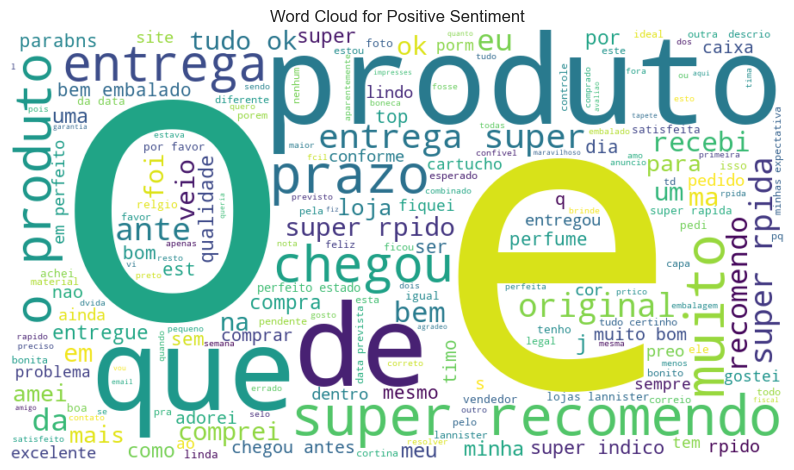

In [350]:
generate_wordcloud(df_sentiment, 'Positive')

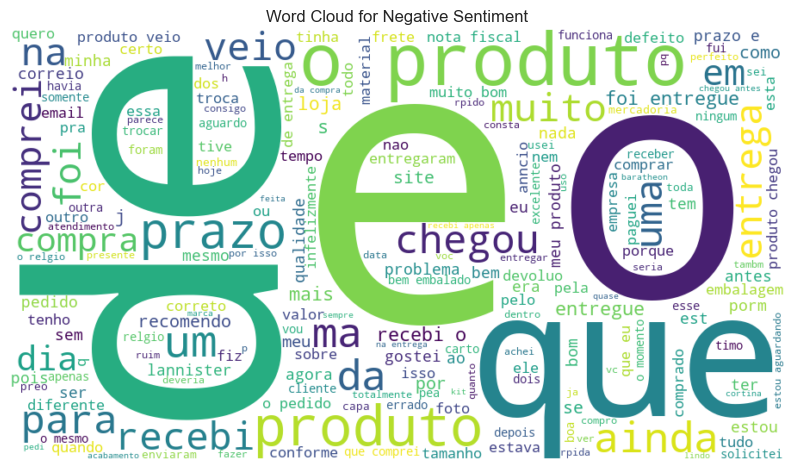

In [351]:
generate_wordcloud(df_sentiment, 'Negative')

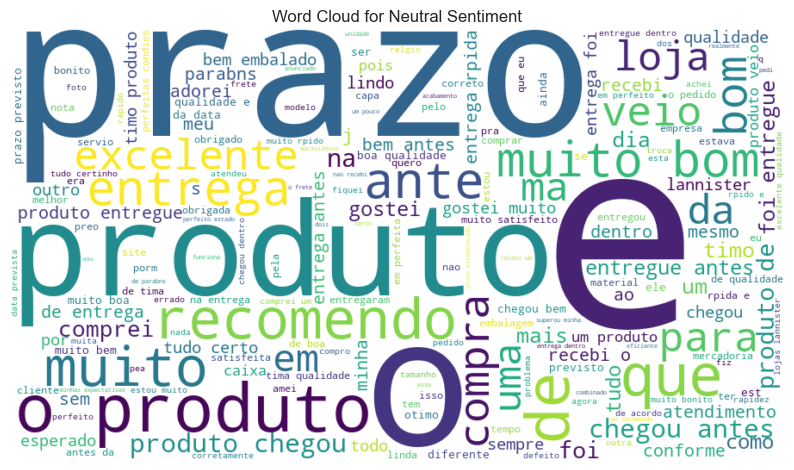

In [352]:
generate_wordcloud(df_sentiment, 'Neutral')

In [353]:
df_sentiment['true_sentiment'] = df_sentiment['review_comment_message_clean_sentiment']

In [354]:
y_true = df_sentiment['true_sentiment']
y_pred = df_sentiment['review_comment_message_clean_sentiment']

In [359]:
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       851
     Neutral       1.00      1.00      1.00      1938
    Positive       1.00      1.00      1.00       229

    accuracy                           1.00      3018
   macro avg       1.00      1.00      1.00      3018
weighted avg       1.00      1.00      1.00      3018



array([[ 851,    0,    0],
       [   0, 1938,    0],
       [   0,    0,  229]])

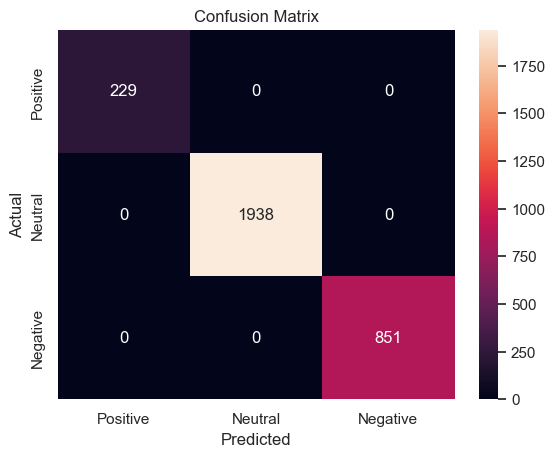

In [357]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=['Positive', 'Neutral', 'Negative'])

sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
